In [60]:
import numpy as np
import matplotlib.pyplot as plt
import os
from physynthtrainer.burstGen import (
    generate_quasi_periodic_signal, 
    biGaussian, 
    generate_type_iii_burst, 
    generate_many_random_t3_bursts, 
    create_radio_burst_hash_table,
    added_noise
)
from physynthtrainer.utils import (
    paint_arr_to_jpg, 
    export_yolo_label, 
    plot_jpg_labeling,
    save_config_to_yml, 
    load_config_from_yml
)
from physynthtrainer import freqDrift

# reload actively
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of physynthtrainer failed: Traceback (most recent call last):
  File "/opt/devel/peijin/solarml/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/opt/devel/peijin/solarml/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/opt/devel/peijin/solarml/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/opt/devel/peijin/solarml/lib/python3.11/site-packages/physynthtrainer/__init__.py", line 5, in <module>
    from .burstGen import (
ImportError: cannot import name 'generate_type_2_burst' from 'physynthtrainer.burstGen' (/opt/devel/peij

Plotted 1 labels from ./demo_bursts.txt


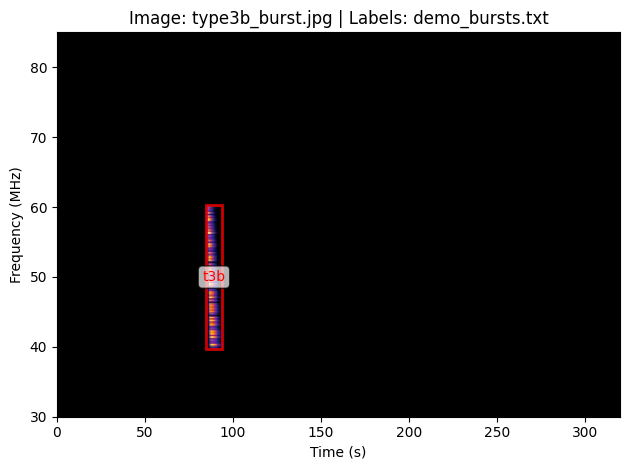

In [61]:
import numpy as np
from physynthtrainer.burstGen import generate_type_iii_burst
from physynthtrainer.utils import paint_arr_to_jpg, visualize_mask_and_bboxes

# Generate a single type III burst
img_bursts, mask, bbox = generate_type_iii_burst(fine_structure=True)

# Save the burst image
paint_arr_to_jpg(img_bursts, filename='type3b_burst.jpg')
# export the label file
label_file = export_yolo_label([bbox],  ['t3b'], output_dir='./',  base_filename='demo_bursts')


plot_jpg_labeling(img_file='type3b_burst.jpg', labeling_txt=label_file)

Create synthetic data for yolo training

Data description
* size: 640x640
* freq range: 24 to 88 MHz
* time cadence: every one sec per pix

Generated burst image shape: (640, 640)
Burst time range: 83.8 to 89.8 seconds


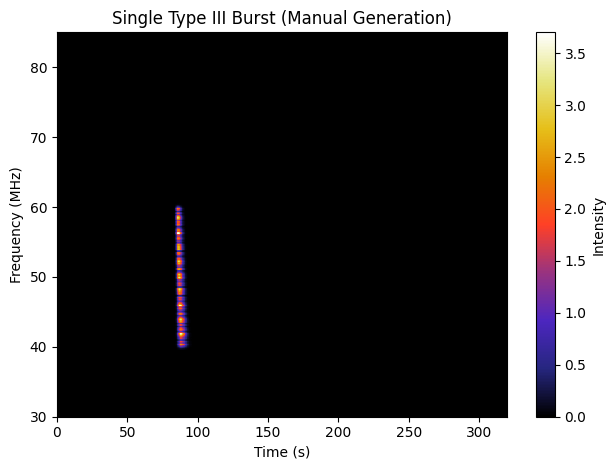

In [62]:
# create single burst with deterministic parameters

# Parameters
freq_range = [30, 85]  # MHz
t_res = 0.5            # sec
t_start = 0.0          # sec
N_freq = 640
N_time = 640

# Burst parameters
v_beam = 0.15          # c
t0_burst = 80.0        # sec
decay_t_dur_100Mhz = 1 # sec
Burst_intensity = 1.0
burststarting_freq = 40.0
burstending_freq = 60.0
edge_freq_ratio = 0.01
fine_structure = True

# Create arrays
img_bursts = np.zeros((N_time, N_freq))
t_ax = t_start + np.arange(0, N_time) * t_res
f_ax = np.linspace(freq_range[0], freq_range[1], N_freq)

edge_freq = (burstending_freq - burststarting_freq) * edge_freq_ratio
t_burst = []

# Add fine structure modulation if enabled
if fine_structure:
    freq_modulation = generate_quasi_periodic_signal(
        t_arr=f_ax, base_freq=0.5, num_harmonics=5, 
        noise_level=0, freqvar=0.1
    )
    # normalize to 0-1
    freq_modulation = (freq_modulation - np.min(freq_modulation)) / (np.max(freq_modulation) - np.min(freq_modulation))

# Generate burst for each frequency
for pix_f, f_this in enumerate(f_ax):
    t_burst.append(freqDrift.freq_drift_t_f(f_ax[pix_f], v_beam, t0_burst))
    decay_t_dur_this = decay_t_dur_100Mhz * (100.0/f_this)
    burst_amp = Burst_intensity * (np.tanh((f_this - burststarting_freq) / edge_freq)+1) * (np.tanh((burstending_freq - f_this) / edge_freq)+1)
    burst_amp = burst_amp * freq_modulation[pix_f] if fine_structure else burst_amp
    l_curve = biGaussian(t_ax, t_burst[-1], decay_t_dur_this, decay_t_dur_this/2, burst_amp)
    img_bursts[:, pix_f] += l_curve

t_burst = np.array(t_burst)

print(f"Generated burst image shape: {img_bursts.shape}")
print(f"Burst time range: {t_burst.min():.1f} to {t_burst.max():.1f} seconds")

# Plot the result
plt.figure()
plt.imshow(img_bursts.T, 
            cmap='CMRmap',
            interpolation='nearest', aspect='auto', origin='lower', 
           extent=[t_start, t_start + N_time * t_res, freq_range[0], freq_range[1]])
plt.colorbar(label='Intensity')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (MHz)')
plt.title('Single Type III Burst (Manual Generation)')
plt.tight_layout()
plt.savefig('demo_single_burst_manual.png', dpi=150, bbox_inches='tight')
plt.show()

Generated burst image shape: (640, 640)
Bounding box (YOLO format): [np.float64(0.278125), np.float64(0.3671875), np.float64(0.028125), np.float64(0.409375)]
Has fine structure (t3b): True


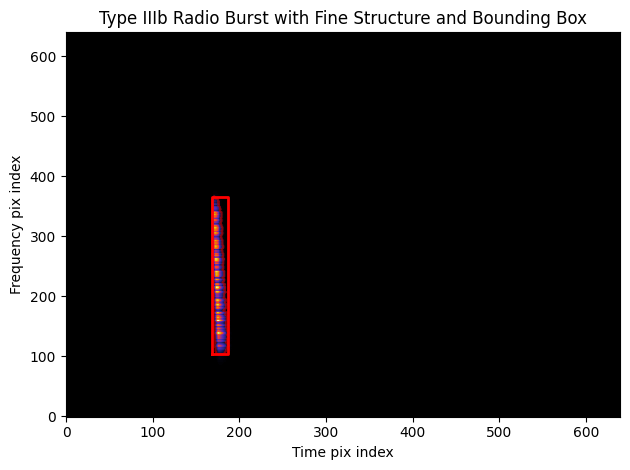

In [63]:
# mask and bbox

# Generate burst using built-in function
img_bursts, mask, bbox = generate_type_iii_burst(
    freq_range=[30, 85], 
    t_res=0.5, 
    t_start=0.0, 
    N_freq=640, 
    N_time=640,
    v_beam=0.15, 
    t0_burst=80.0, 
    decay_t_dur_100Mhz=1.0,
    Burst_intensity=1.0, 
    burststarting_freq=40.0,
    burstending_freq=60.0, 
    edge_freq_ratio=0.05,
    fine_structure=True
)

print(f"Generated burst image shape: {img_bursts.shape}")
print(f"Bounding box (YOLO format): {bbox}")
print(f"Has fine structure (t3b): {True}")

# Plot the result with bounding box
plt.figure()
plt.imshow(img_bursts.T, interpolation='nearest', 
           cmap='CMRmap',
           aspect='auto', origin='lower')

# Plot mask and bbox
plt.contour(mask.T, levels=[0.5], colors='r', alpha=0.5)

# Convert YOLO bbox to matplotlib format
img_height, img_width = mask.shape
x_center, y_center, width, height = bbox

xmin = int((x_center - width / 2) * img_width)
xmax = int((x_center + width / 2) * img_width)
ymin = int((y_center - height / 2) * img_height)
ymax = int((y_center + height / 2) * img_height)

plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], 'r-', linewidth=2)
#plt.colorbar(label='Intensity')
plt.xlabel('Time pix index')
plt.ylabel('Frequency pix index')
plt.title('Type IIIb Radio Burst with Fine Structure and Bounding Box')
plt.tight_layout()
plt.savefig('demo_single_burst_function.png', dpi=150, bbox_inches='tight')
plt.show()

Generating multiple bursts...
Generated 23 bursts
Image shape: (640, 640)
Number of t3b (fine structure): 5
Number of t3 (no fine structure): 18


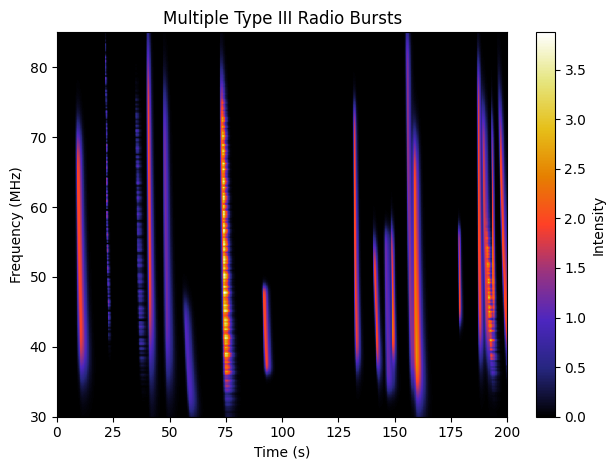

In [109]:
# many type III bursts

t_burst_hash, f_ax, v_ax = create_radio_burst_hash_table(
    freq_range=[30, 85], 
    N_freq=640, 
    v_range=[0.05, 0.5], 
    N_v=200
)

# Generate multiple bursts
print("Generating multiple bursts...")
img_bursts, bursts, is_t3b = generate_many_random_t3_bursts(
    n_bursts=30, 
    use_hash_table=True, 
    freq_range=[35, 80],
    hash_table=t_burst_hash, 
    v_hash=v_ax
)

print(f"Generated {len(bursts)} bursts")
print(f"Image shape: {img_bursts.shape}")
print(f"Number of t3b (fine structure): {sum(is_t3b)}")
print(f"Number of t3 (no fine structure): {len(is_t3b) - sum(is_t3b)}")

# Plot the result
plt.figure()
plt.imshow(img_bursts.T, interpolation='nearest',
           cmap='CMRmap',
           aspect='auto', origin='lower',
           extent=[0, 200, 30, 85])
plt.colorbar(label='Intensity')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (MHz)')
plt.title('Multiple Type III Radio Bursts')
plt.tight_layout()
plt.savefig('demo_multiple_bursts.png', dpi=150, bbox_inches='tight')
plt.show()

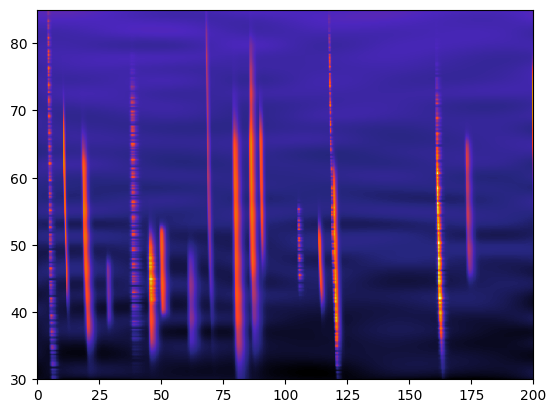

In [95]:


noise_bg = added_noise(t_ax, f_ax, noise_size=[32,8], noise_level=0.35)

y = np.linspace(0.1, 1, 640)
const_bg = np.tile(y[:, np.newaxis], (1, 640))

img_bursts_noisy = img_bursts + noise_bg.T+ const_bg.T
plt.imshow(img_bursts_noisy.T, interpolation='nearest', 
        cmap='CMRmap', aspect='auto', origin='lower',
           extent=[0, 200, 30, 85])

In [96]:

label_file = export_yolo_label(
    bursts, 
    is_t3b, 
    output_dir='./', 
    base_filename='demo_bursts'
)

print(f"YOLO labels exported to: {label_file}")

# Display the first few labels
with open(label_file, 'r') as f:
    lines = f.readlines()
    print(f"\nFirst 5 labels (class x_center y_center width height):")
    for i, line in enumerate(lines[:5]):
        class_id = int(line.split()[0])
        class_name = "t3b" if class_id == 1 else "t3"
        print(f"  {i+1}: {line.strip()} ({class_name})")



paint_arr_to_jpg(img_bursts_noisy, 'demo_bursts.jpg')

YOLO labels exported to: ./demo_bursts.txt

First 5 labels (class x_center y_center width height):
  1: 0 0.105469 0.361719 0.035937 0.710938 (t3)
  2: 0 0.236719 0.236719 0.029687 0.426563 (t3)
  3: 0 0.317969 0.215625 0.035937 0.350000 (t3)
  4: 0 0.413281 0.411719 0.042188 0.823438 (t3)
  5: 0 0.146875 0.235937 0.018750 0.221875 (t3)


In [70]:
config_file = save_config_to_yml(
        freq_range=[30, 85],
        t_res=0.5,
        t_start=0.0,
        N_freq=640,
        N_time=640,
        output_file='base.yml'
    )

Plotted 22 labels from demo_bursts.txt


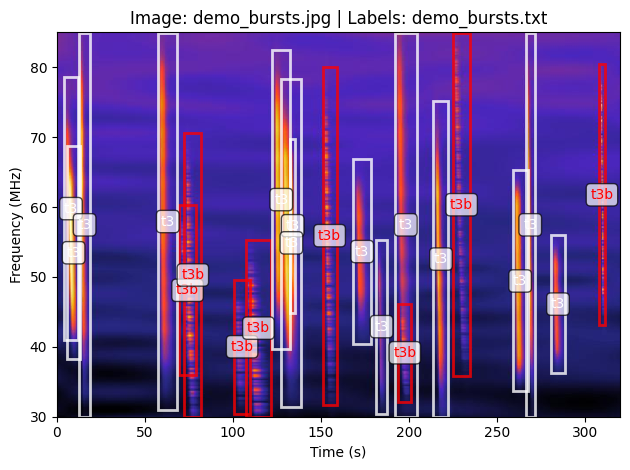

In [71]:
plot_jpg_labeling('demo_bursts.jpg', 'demo_bursts.txt','base.yml')

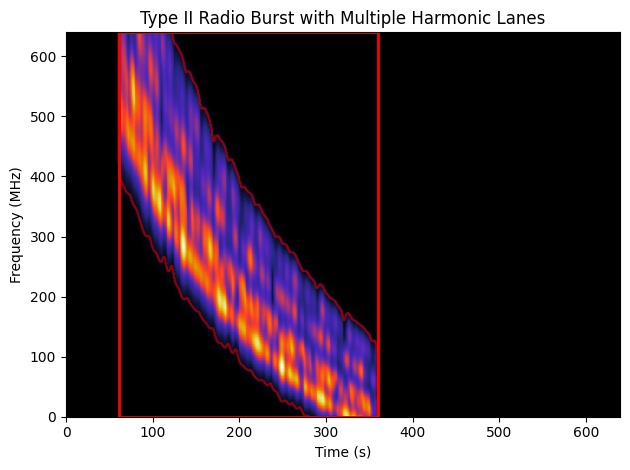

In [75]:
from physynthtrainer import burstGen

img_bursts, mask, bboxes =burstGen.generate_type_2_burst(
        freq_range=[30, 85],
        t_res=0.5,
        t_start=0.0,
        N_freq=640,
        N_time=640,
        v_shock=800,  # km/s
        t_s_start=30.0,
        t_s_end=180.0,
        eff_starting_freq=100,  # MHz
        laneNUM=6,
        harmonic_overlap=False
    )

plt.imshow(img_bursts.T, interpolation='nearest', aspect='auto', origin='lower', cmap='CMRmap')

plt.ylim(0, 640)

# Plot mask contour
plt.contour(mask.T, levels=[0.5], colors='r', alpha=0.5)


# Convert YOLO bbox to matplotlib format

if len(bboxes) > 0:
    for bbox in bboxes:
        x_center, y_center, width, height = bbox

        img_height, img_width = mask.shape

        xmin = int((x_center - width / 2) * img_width)
        xmax = int((x_center + width / 2) * img_width)
        ymin = int((y_center - height / 2) * img_height)
        ymax = int((y_center + height / 2) * img_height)

        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], 'r-', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (MHz)')
plt.title('Type II Radio Burst with Multiple Harmonic Lanes')
plt.tight_layout()
plt.savefig('test_type_2_burst.png', dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
bbox

[np.float64(0.34375),
 np.float64(0.55078125),
 np.float64(0.4375),
 np.float64(0.8984375)]

In [ ]:
bgfile = '/data07/peijinz/ML/type3MLgen/PhySynthTrainer/physynthtrainer/data/latest_data.2.npz'



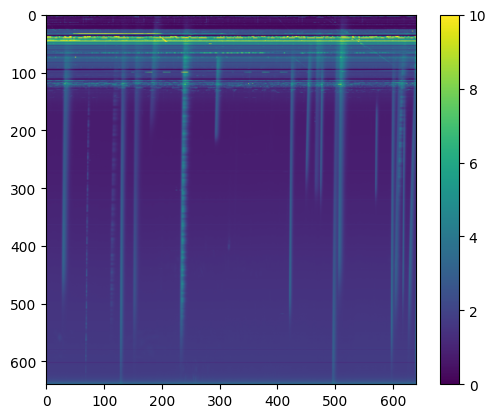

In [110]:


noise_data = np.load(bgfile)

from skimage.transform import resize

noise_bg_overlap = resize(noise_data['data'], img_bursts.shape, order=1)


plt.imshow(img_bursts.T + noise_bg_overlap.T, vmax=10,vmin=0)
plt.colorbar()
plt.show()





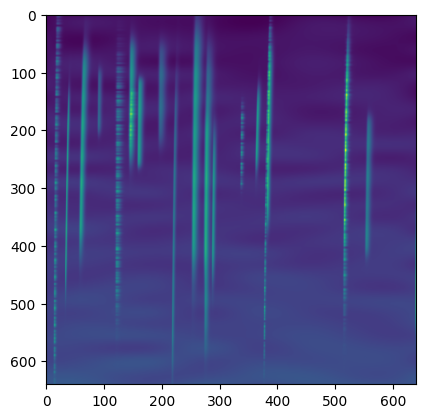

In [111]:
plt.imshow(img_bursts_noisy.T)

In [ ]:
from physynthtrainer import utils

utils.paint_arr_to_jpg(img_bursts*10 + noise_bg_overlap, 'img_bursts_noisy.jpg', scaling='linear', vmax=100,vmin=0.5)

np.float64(3.875293797883579)